<a href="https://colab.research.google.com/github/shashanks33/ML-Prac/blob/master/Bangalore-Housing/Bangalore_housing_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split

uploaded = files.upload()

In [0]:
df = pd.read_csv('Bengaluru_House_Data.csv')
# print(df)

In [6]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [7]:
df1 = df.drop(['society', 'availability', 'area_type'], axis=1)
# df1.head()
df1.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [0]:
df1['balcony'].fillna(1, inplace=True)
df1['bath'].fillna(1.34630482373, inplace=True) # 1.346... = mean/2
df1['balcony'].replace(to_replace=0.0, value=1.0, inplace=True)

In [9]:
df2 = df1.dropna()
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [10]:
#  Converts 1 bhk/1 bedroom into an interger value of 1
df2['BHK'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,location,size,total_sqft,bath,balcony,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,1.0,51.00,2


In [0]:
# Since total_sqft has non float values like 2100 - 2850
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [12]:
df2[~df2['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,balcony,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.000000,1.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,1.346305,1.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,1.346305,1.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.000000,1.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.000000,1.0,54.005,2


In [0]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [0]:
df3 = df2.copy()
df3.total_sqft = df3.total_sqft.apply(convert_sqft_to_num)
df3['total_sqft'] = df3['total_sqft'].astype(float)

In [0]:
df4 = df3.copy()

In [0]:
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft']

In [17]:
# Since the location column has 1304 unique values we will perform dimensional analysis/reduction
# First we strip off extra leading/trailing spaces in each row of location
df4['location'] = df4['location'].apply(lambda x: x.strip())
# List out all the row values of location whuch belong to the same location
location_stats = df4['location'].value_counts(ascending=False)
location_stats

Whitefield                  540
Sarjapur  Road              397
Electronic City             304
Kanakpura Road              273
Thanisandra                 237
                           ... 
vinayakanagar                 1
elachenahalli                 1
Banashankari stage 2          1
DUO Layout                    1
Old Mangammanapalya Road      1
Name: location, Length: 1293, dtype: int64

In [0]:
# len(location_stats[location_stats<=10]) # Equals 1052
# location_stats.values.sum() # Equals 13303
# len(df4.location.unique()) # Equals 1293

In [0]:
# Dimensional reduction 
location_stats_less_than_10 = location_stats[location_stats<=10]
df4['location'] = df4['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
# len(df4['location'].unique()) # Equals 242

In [0]:
# Removing outliers
df4[df4['total_sqft']/df4['BHK']<300]

In [0]:
df5 = df4[~(df4['total_sqft']/df4['BHK']<300)]

In [21]:
# Outlier Removal Using Standard Deviation and Mean
df5['price_per_sqft'].describe()

count     12513.000000
mean       6307.441644
std        4160.931610
min         267.829813
25%        4210.526316
50%        5295.007564
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [0]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sqft)
    std = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft>(m-std)) & (subdf.price_per_sqft<=(m+std))]
    df_out = pd.concat([df_out, reduced_df], ignore_index=True)
  return df_out

In [23]:
df6 = remove_pps_outliers(df5)
df6.shape

(10286, 8)

In [0]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.BHK==2)]
    bhk3 = df[(df.location==location) & (df.BHK==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

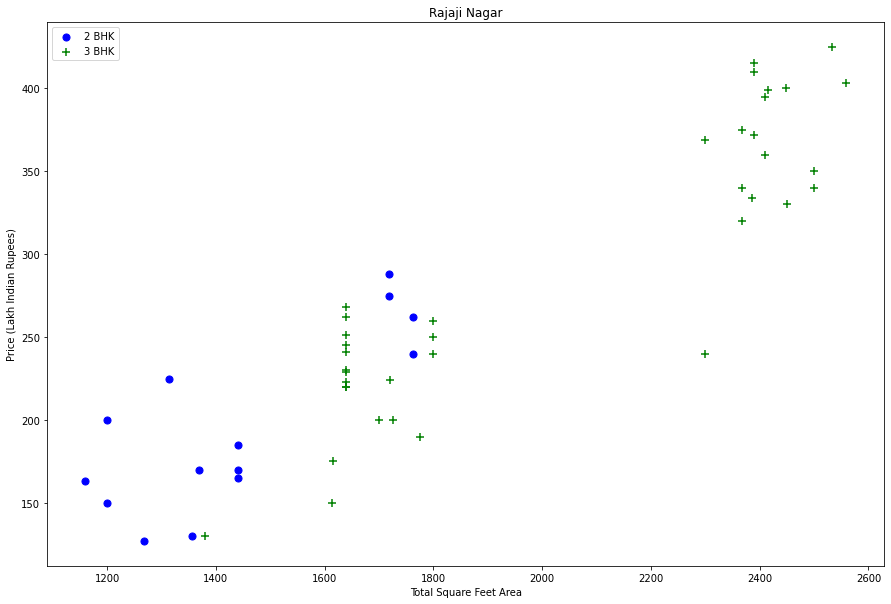

In [25]:
plot_scatter_chart(df6, 'Rajaji Nagar')

In [0]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [27]:
df7 = remove_bhk_outliers(df6)
df7.shape

(7353, 8)

Text(0, 0.5, 'Count')

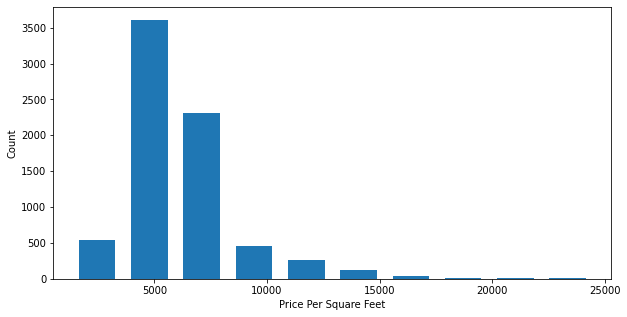

In [28]:
plt.rcParams['figure.figsize'] = (10,5)
plt.hist(df7.price_per_sqft,rwidth=0.7)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [29]:
# Remove outliers using bathroom feature
df7[df7['bath']>10]
df7[df7['bath']>df7['BHK'] + 2]
df8 = df7[df7['bath']<df7['BHK'] + 2]
df8.shape

(7275, 8)

In [0]:
df9 = df8.drop(['size', 'price_per_sqft'], axis=1)
df9.head()

In [0]:
# One hot encodings
dummies = pd.get_dummies(df9['location'])

In [32]:
df10 = pd.concat([df9, dummies.drop('other', axis=1)], axis=1)
# df10.head()

,location,total_sqft,bath,balcony,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,1.0,130.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df11 = df10.drop('location', axis=1)

In [0]:
x = df11.drop('price', axis=1)
y = df11['price']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [44]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
lr_model.score(x_test, y_test)

0.8305910805739383

In [48]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.80756686, 0.77162785, 0.86473812, 0.83580938, 0.81863245])

In [50]:
# from tensorflow import keras
# model = tf.keras.Sequential()
# x_train.shape

(5820, 245)

In [0]:
# Saving the model
import pickle
filename = 'final_practice_bangalore_housing.sav'
pickle.dump(lr_model, open(filename, 'wb'))

In [54]:
# Loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.8305910805739383
